# Serial spawning

I'll need to explain the data layout a bit...  This is using 2D chunked arrays.  Each nodelet has a chunk of consecutive memory.  Every nodelet has a pointer to each nodelet's local memory.  On the Emu platform, *all* pointers are global.

```c
// #define INDEX(PTR, BLOCK, I) (PTR[I/BLOCK][I%BLOCK])
#define INDEX(PTR, BLOCK, I) (PTR[I >> PRIORITY(BLOCK)][I&(BLOCK-1)])

noinline void
serial_spawn_add_worker(long begin, long end, global_stream_data *data)
{
    long block_sz = data->n / NODELETS();
    for (long i = begin; i < end; ++i) {
        INDEX(data->c, block_sz, i) = INDEX(data->a, block_sz, i) + INDEX(data->b, block_sz, i);
    }
}

// serial_spawn - spawn one thread to handle each grain-sized chunk of the range
void
global_stream_add_serial_spawn(global_stream_data * data)
{
    long grain = data->n / data->num_threads;
    for (long i = 0; i < data->n; i += grain) {
        long begin = i;
        long end = begin + grain <= data->n ? begin + grain : data->n;
        cilk_spawn serial_spawn_add_worker(begin, end, data);
    }
    cilk_sync;
}
```

But first, some boring building...

In [1]:
%%bash
mkdir build
cd build
cmake ../emu-microbench -DCMAKE_BUILD_TYPE=Release -DCMAKE_TOOLCHAIN_FILE=../emu-microbench/cmake/emu-toolchain.cmake
make global_stream

-- Using Emu1 toolchain in /usr/local/emu
-- Using Emu1 toolchain in /usr/local/emu
-- The C compiler identification is Clang 3.9.0
-- The CXX compiler identification is Clang 3.9.0
-- Check for working C compiler: /usr/local/emu/bin/emu-cc.sh
-- Check for working C compiler: /usr/local/emu/bin/emu-cc.sh -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/local/emu/bin/emu-cc.sh
-- Check for working CXX compiler: /usr/local/emu/bin/emu-cc.sh -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found emu_c_utils: /usr/local/emu/lib/libemu_c_utils.a  
-- Configuring done
-- Generating done
-- Build files have been written to: /home/eriedy3/demo/build
Scanning dependencies of target global_stream
[ 50%] Building C object CMakeFiles/global_st

In [2]:
%%bash
cp build/global_stream.mwx .
mkdir serial_data
mkdir serial_remote_data
mkdir recursive_remote_data

## Now the actual running, using small parameters for emulation

In [4]:
!cd serial_data && emusim.x --capture_timing_queues -- ../global_stream.mwx serial_spawn 12 512 1


        SystemC 2.3.1-Accellera --- Feb 15 2019 08:53:31
        Copyright (c) 1996-2014 by all Contributors,
        ALL RIGHTS RESERVED
Start untimed simulation with local date and time= Sun Apr 14 00:18:27 2019

Initializing arrays with 12288 elements each (0 MiB total, 0 MiB per nodelet)
Doing vector addition using serial_spawn
End untimed simulation with local date and time= Sun Apr 14 00:18:53 2019

SysC Enumeration done. Program launching...
Simulation @0 s with local date and time= Sun Apr 14 00:18:53 2019

Simulation @1 ms with local date and time= Sun Apr 14 00:18:58 2019

Simulation @2 ms with local date and time= Sun Apr 14 00:19:02 2019

Simulation @3 ms with local date and time= Sun Apr 14 00:19:07 2019

Simulation @4 ms with local date and time= Sun Apr 14 00:19:12 2019

Simulation @5 ms with local date and time= Sun Apr 14 00:19:17 2019

Simulation @6 ms with local date and time= Sun Apr 14 00:19:21 2019

Simulation @7 ms with local date and time= Sun Apr 14 00:19:26 2

In [5]:
!cd serial_data && make_cdc_plots.py global_stream.cdc && make_tqd_plots.py global_stream.tqd

Generating global_stream_migration_map.png
Generating global_stream_local_memops.png
Generating global_stream_remotes_map.png
Generating global_stream_live_threads.png
Generating global_stream_DDR.png
Generating global_stream_NLET_REGSETS_USED.png


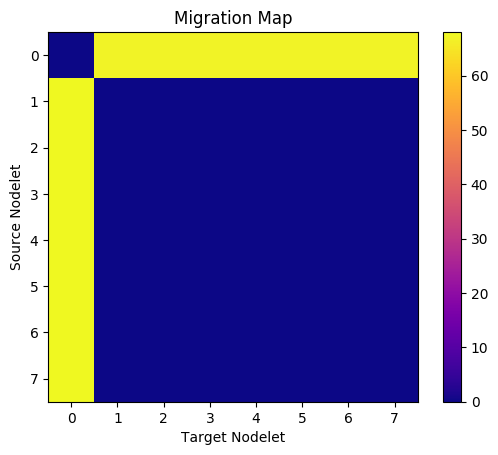

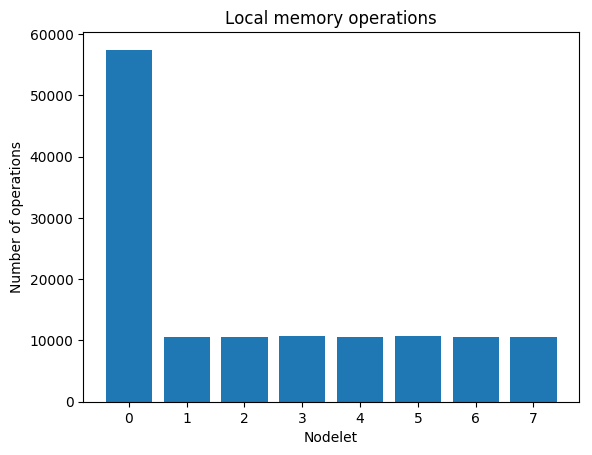

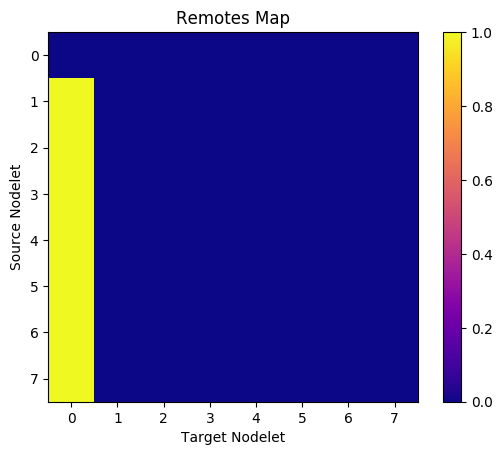

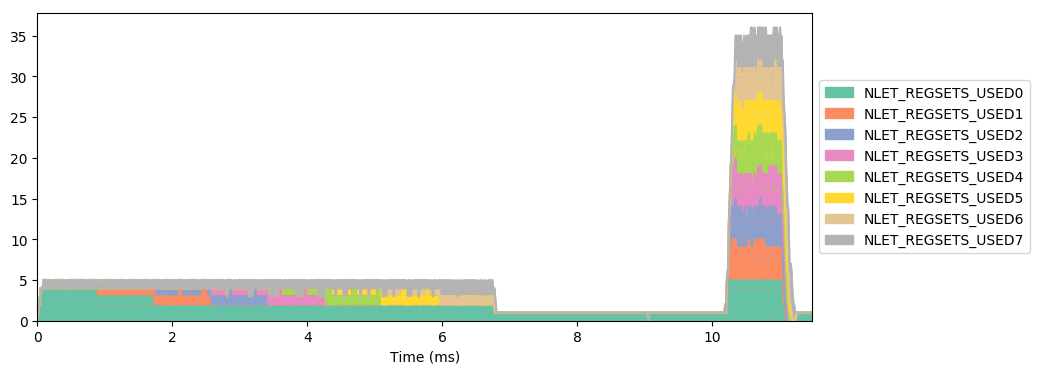

In [6]:
from IPython.display import Image, display
display(Image(filename="serial_data/global_stream_migration_map.png"))
display(Image(filename="serial_data/global_stream_local_memops.png"))
display(Image(filename="serial_data/global_stream_remotes_map.png"))
display(Image(filename="serial_data/global_stream_NLET_REGSETS_USED.png"))

# Remote spawning

Note, this decodes the data earlier...

```c
noinline void
serial_remote_spawn_level2(long begin, long end, long * a, long * b, long * c)
{
    for (long i = begin; i < end; ++i) {
        c[i] = a[i] + b[i];
    }
}

noinline void
serial_remote_spawn_level1(long * a, long * b, long * c, long n, long grain)
{
    for (long i = 0; i < n; i += grain) {
        long begin = i;
        long end = begin + grain <= n ? begin + grain : n;
        cilk_spawn serial_remote_spawn_level2(begin, end, a, b, c);
    }
    cilk_sync;
}

// serial_remote_spawn - remote spawn a thread on each nodelet, then do a serial spawn locally
void
global_stream_add_serial_remote_spawn(global_stream_data * data)
{
    // Each thread will be responsible for the elements on one nodelet
    long local_n = data->n / NODELETS();
    // Calculate the grain so we get the right number of threads globally
    long grain = data->n / data->num_threads;
    // Spawn a thread on each nodelet
    for (long i = 0; i < NODELETS(); ++i) {
        cilk_spawn_at(data->a[i]) serial_remote_spawn_level1(data->a[i], data->b[i], data->c[i], local_n, grain);
    }
    cilk_sync;
}
```

In [7]:
!cd serial_remote_data && emusim.x --capture_timing_queues -- ../global_stream.mwx serial_remote_spawn 12 512 1


        SystemC 2.3.1-Accellera --- Feb 15 2019 08:53:31
        Copyright (c) 1996-2014 by all Contributors,
        ALL RIGHTS RESERVED
Start untimed simulation with local date and time= Sun Apr 14 00:20:49 2019

Initializing arrays with 12288 elements each (0 MiB total, 0 MiB per nodelet)
Doing vector addition using serial_remote_spawn
End untimed simulation with local date and time= Sun Apr 14 00:21:16 2019

SysC Enumeration done. Program launching...
Simulation @0 s with local date and time= Sun Apr 14 00:21:16 2019

Simulation @1 ms with local date and time= Sun Apr 14 00:21:21 2019

Simulation @2 ms with local date and time= Sun Apr 14 00:21:25 2019

Simulation @3 ms with local date and time= Sun Apr 14 00:21:29 2019

{"spawn_mode":"serial_remote_spawn","log2_num_elements":12,"num_threads":512,"num_nodelets":8,"num_bytes_per_element":24,"trial":0,"region_name":"serial_remote_spawn","time_ms":2.49,"ticks":373859}
Simulation @4 ms with local date and time= Sun Apr 14 00:21:34 201

In [8]:
!cd serial_remote_data && make_cdc_plots.py global_stream.cdc && make_tqd_plots.py global_stream.tqd

Generating global_stream_migration_map.png
Generating global_stream_local_memops.png
Generating global_stream_remotes_map.png
Generating global_stream_live_threads.png
Generating global_stream_DDR.png
Generating global_stream_NLET_REGSETS_USED.png


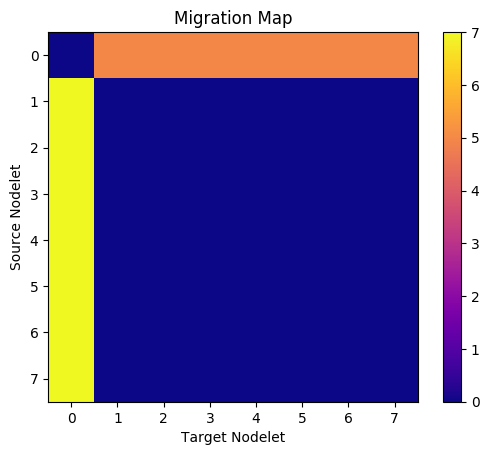

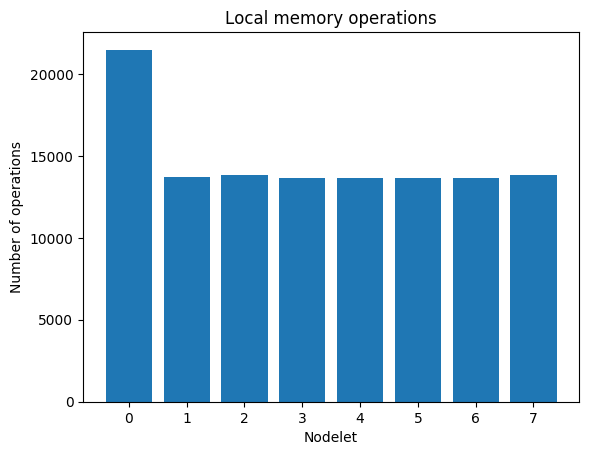

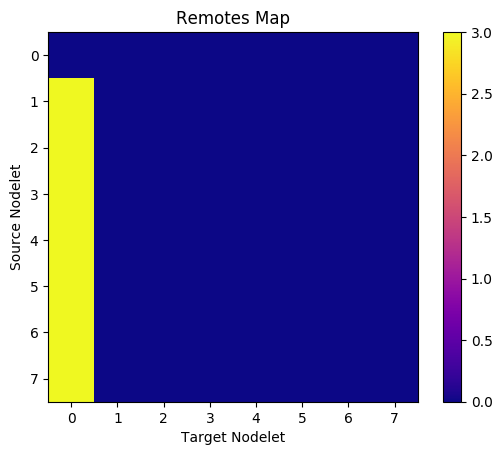

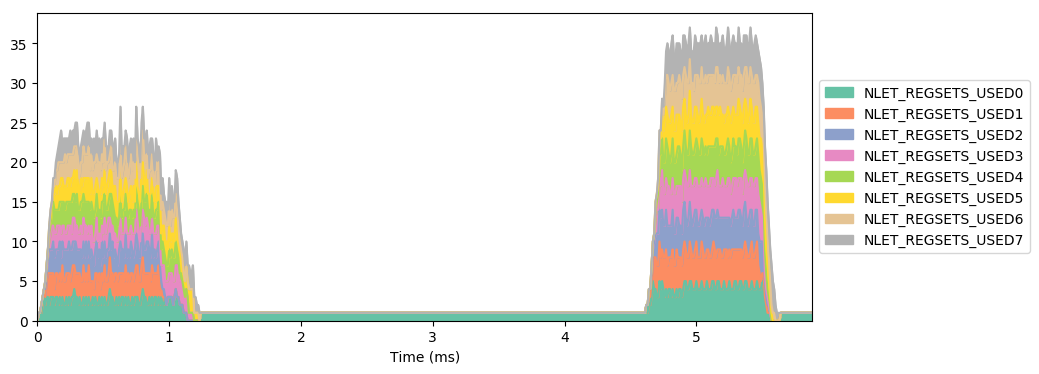

In [9]:
display(Image(filename="serial_remote_data/global_stream_migration_map.png"))
display(Image(filename="serial_remote_data/global_stream_local_memops.png"))
display(Image(filename="serial_remote_data/global_stream_remotes_map.png"))
display(Image(filename="serial_remote_data/global_stream_NLET_REGSETS_USED.png"))

# *Recursive* remote spawning

```c
noinline void
recursive_remote_spawn_level2_worker(long begin, long end, long * a, long * b, long * c)
{
    for (long i = begin; i < end; ++i) {
        c[i] = a[i] + b[i];
    }
}

#define RECURSIVE_CILK_SPAWN(BEGIN, END, GRAIN, FUNC, ...)          \
do {                                                                \
    long low = BEGIN;                                               \
    long high = END;                                                \
                                                                    \
    for (;;) {                                                      \
        /* How many elements in my range? */                        \
        long count = high - low;                                    \
                                                                    \
        /* Break out when my range is smaller than the grain size */\
        if (count <= GRAIN) break;                                  \
                                                                    \
        /* Divide the range in half */                              \
        /* Invariant: count >= 2 */                                 \
        long mid = low + count / 2;                                 \
                                                                    \
        /* Spawn a thread to deal with the lower half */            \
        cilk_spawn FUNC(low, mid, GRAIN, __VA_ARGS__);              \
                                                                    \
        low = mid;                                                  \
    }                                                               \
                                                                    \
    /* Recursive base case: call worker function */                 \
    FUNC ## _worker(low, high, __VA_ARGS__);                        \
} while (0)

noinline void
recursive_remote_spawn_level2(long begin, long end, long grain, long * a, long * b, long * c)
{
    RECURSIVE_CILK_SPAWN(begin, end, grain, recursive_remote_spawn_level2, a, b, c);
}

noinline void
recursive_remote_spawn_level1(long low, long high, global_stream_data * data)
{
    for (;;) {
        long count = high - low;
        if (count == 1) break;
        long mid = low + count / 2;
        cilk_spawn_at(data->a[low]) recursive_remote_spawn_level1(low, mid, data);
        low = mid;
    }

    /* Recursive base case: call worker function */
    long local_n = data->n / NODELETS();
    long grain = data->n / data->num_threads;
    recursive_remote_spawn_level2(0, local_n, grain, data->a[low], data->b[low], data->c[low]);
}

// recursive_remote_spawn - Recursively spawns threads to divice up the loop range, using remote spawns where possible.
void
global_stream_add_recursive_remote_spawn(global_stream_data * data)
{
    recursive_remote_spawn_level1(0, NODELETS(), data);
}
```

In [10]:
!cd recursive_remote_data && emusim.x --capture_timing_queues -- ../global_stream.mwx recursive_remote_spawn 12 512 1


        SystemC 2.3.1-Accellera --- Feb 15 2019 08:53:31
        Copyright (c) 1996-2014 by all Contributors,
        ALL RIGHTS RESERVED
Start untimed simulation with local date and time= Sun Apr 14 00:22:39 2019

Initializing arrays with 12288 elements each (0 MiB total, 0 MiB per nodelet)
Doing vector addition using recursive_remote_spawn
End untimed simulation with local date and time= Sun Apr 14 00:23:06 2019

SysC Enumeration done. Program launching...
Simulation @0 s with local date and time= Sun Apr 14 00:23:06 2019

Simulation @1 ms with local date and time= Sun Apr 14 00:23:13 2019

Simulation @2 ms with local date and time= Sun Apr 14 00:23:20 2019

Simulation @3 ms with local date and time= Sun Apr 14 00:23:26 2019

Simulation @4 ms with local date and time= Sun Apr 14 00:23:31 2019

Simulation @5 ms with local date and time= Sun Apr 14 00:23:35 2019

Simulation @6 ms with local date and time= Sun Apr 14 00:23:40 2019

{"spawn_mode":"recursive_remote_spawn","log2_num_eleme

In [12]:
!cd recursive_remote_data && make_cdc_plots.py global_stream.cdc && make_tqd_plots.py global_stream.tqd

Generating global_stream_migration_map.png
Generating global_stream_local_memops.png
Generating global_stream_remotes_map.png
Generating global_stream_live_threads.png
Generating global_stream_DDR.png
Generating global_stream_NLET_REGSETS_USED.png


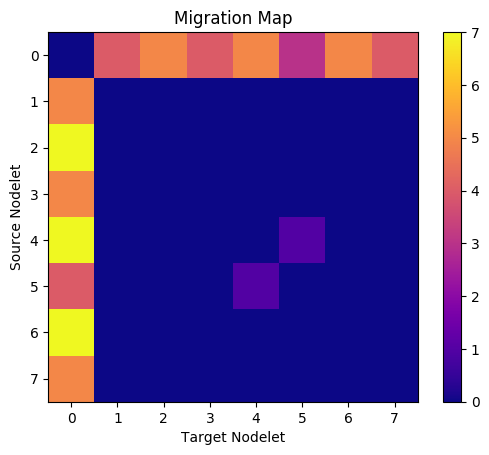

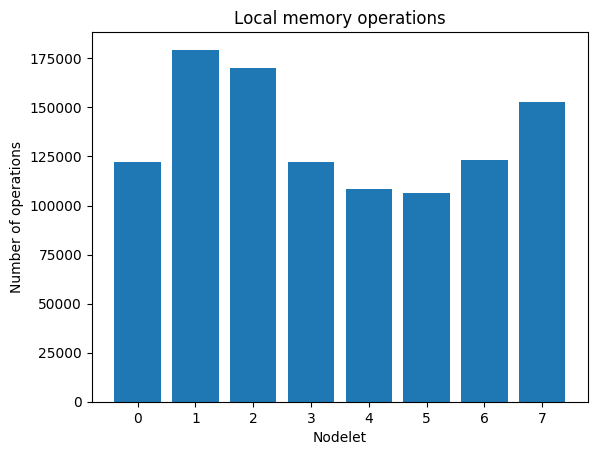

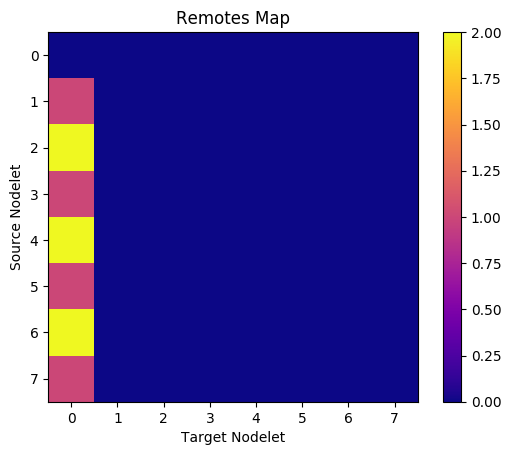

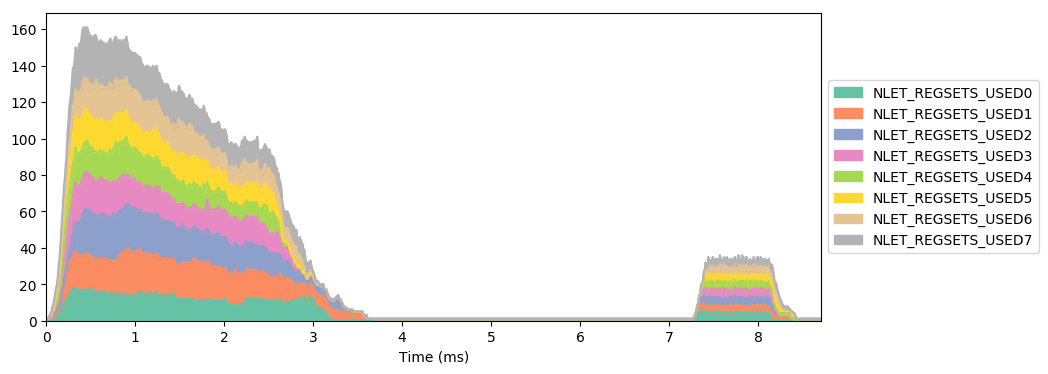

In [13]:
display(Image(filename="recursive_remote_data/global_stream_migration_map.png"))
display(Image(filename="recursive_remote_data/global_stream_local_memops.png"))
display(Image(filename="recursive_remote_data/global_stream_remotes_map.png"))
display(Image(filename="recursive_remote_data/global_stream_NLET_REGSETS_USED.png"))

# And now on the Emu Chick...

`~/ssh/.config` is set up for easy proxy access to the nodes by jumping through karrawingi-login, but you'll need to set up the environment a little:
```bash
eval (ssh-agent)
ssh-add # no password
```

Then the following should work, replacing n0 with the node you're going to use:

```bash
scp global_stream.mwx n0:
ssh n0
emu_handler_and_loader 0 0 -- global_stream.mwx recursive_remote_spawn 24 512 1
```